# This is a demonstration of a downstream task (text classification) of the BERT model with the use of Google's TPUs

In [2]:
# Import neccessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
import shutil
import tensorflow_hub as hub
import tensorflow.keras as K
from keras.utils import to_categorical
import pandas as pd

tf.get_logger().setLevel('ERROR')
AUTO = tf.data.experimental.AUTOTUNE

In [3]:
print(tf.__version__)
print(K.__version__)

2.4.1
2.4.0


### Connect to the TPU worker

The following code connects to the TPU worker and changes TensorFlow's default device to the CPU device on the TPU worker. It also defines a TPU distribution strategy that you will use to distribute model training onto the 8 separate TPU cores available on this one TPU worker. See TensorFlow's [TPU guide](https://www.tensorflow.org/guide/tpu) for more information.

In [4]:

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


In [5]:
# View some info of the TPU in this colaboratory
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

  Timestamp: 06:25:07
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%




In [7]:
#To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores). 
#At this size, the 128x128 hardware matrix multipliers of the TPU (see hardware section below) are most likely to be kept busy. 
#You start seeing interesting speedups from a batch size of 8 per core though. In the sample above, the batch size is scaled with the core count

# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default)
MIXED_PRECISION = False
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    print('8')
    
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    print('1')
    
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    print('else')
   

8


In [8]:
# Install transformers and download the greek specific file for model and tokenizer
# This is done only for testing some inputs
# For fine tuning the BERT model we have to load again the model when we build it inside strategy.scope()
!pip install transformers
from transformers import AutoTokenizer, TFAutoModel
from transformers import AdamWeightDecay

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = TFAutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")


     |████████████████████████████████| 2.3MB 6.9MB/s 
     |████████████████████████████████| 3.3MB 31.8MB/s 
     |████████████████████████████████| 901kB 45.7MB/s 


Some layers from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
model.summary()
print()
model
print()
tokenizer

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  112921344 
Total params: 112,921,344
Trainable params: 112,921,344
Non-trainable params: 0
_________________________________________________________________




PreTrainedTokenizerFast(name_or_path='nlpaueb/bert-base-greek-uncased-v1', vocab_size=35000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

#GRGE example

In [10]:
# Load the .csv file
df = pd.read_csv("/content/GRGE_sentiment.csv")
df

,Unnamed: 0,Text,Polarity1
0,0,Επιχείρηση Βολευτική έδρα! Βασίλης Οικονόμου:...,Negative
1,1,Κ ά β ο ς: Ψηφοδέλτιο ΣΥΡΙΖΑ Κορινθίας - Πού π...,Negative
2,2,@Dora_Bakoyannis Αυτο-καρφώνεσαι όταν αναρωτιέ...,Positive
3,3,Κόμμα «σκαντζόχοιρος»: «Σφαγή» πασοκογενών από...,Neutral
4,4,Και γαμώ και την Νέα Δημοκρατία γιατί ειμαι πο...,Negative
...,...,...,...
1635,1635,Κουτσούμπας: Δεν θα γίνουμε κερασάκι στην αντι...,Negative
1636,1636,Θέλουμε μια Ελλάδα με πολιτικούς σαν την κ.Φωτ...,Negative
1637,1637,"Για διαχωρισμό κράτους-εκκλησίας, ομόφυλο γάμο...",Negative
1638,1638,ΓΙΑΝΝΕΝΑ:Στην πρώτη γραμμή της προεκλογικής μά...,Neutral


In [11]:
#View frst 10 entries
text_list = df['Text'].to_list()
print(text_list[:10])
polarity = df["Polarity1"].to_list()
print(polarity[:10])

['Επιχείρηση Βολευτική έδρα!  Βασίλης Οικονόμου:  Από το ΠΑΣΟΚ διαγράφηκε απο το ΓΑΠ επειδη ΔΕΝ ψήφισε το Μνημόνιο... http://t.co/gPgr1Caqxv', 'Κ ά β ο ς: Ψηφοδέλτιο ΣΥΡΙΖΑ Κορινθίας - Πού πας,ΣΥΡΙΖΑ, με δράμι μυαλό... http://t.co/8eIiKYS7CP', '@Dora_Bakoyannis Αυτο-καρφώνεσαι όταν αναρωτιέσαι ποιον ΠτΔ θα προτείνει ο ΣΥΡΙΖΑ  αποδεχόμενη την νίκη του αντιπάλου.', 'Κόμμα «σκαντζόχοιρος»: «Σφαγή» πασοκογενών από τις λίστες του ΣΥΡΙΖΑ http://t.co/rC7EY67qFY', 'Και γαμώ και την Νέα Δημοκρατία γιατί ειμαι πολιτικο ακκάουντ στην τελική όχι κλαψομούνικο!!!!', 'Ε. Καϊλή: «Ηθικό ζήτημα που θα κριθεί από τον κόσμο» η μετακίνηση της Γκερέκου στη ΝΔ http://t.co/Q4oYSfJjZZ', 'ΔΙΑΒΑΣΤΕ ΣΗΜΕΡΑ ΣΤΗΝ KONTRA NEWS : ΣΙΓΟΥΡΗ ΠΛΕΟΝ Η ΑΥΤΟΔΥΝΑΜΙΑ ΤΟΥ ΣΥΡΙΖΑ ΚΑΘΑΡΙΣΕ Ο ΣΑΜΑΡΑΣ ΓΙΑ ΤΟΝ ΑΛΕΞΗ ΔΥΟ... http://t.co/JZV7IHUTw1', 'Συμφωνεί ο ΣΥΡΙΖΑ στα Εθνικά θέματα με τον Τρεμόπουλο; Ο “οικολόγος” Μιχ. Τρεμόπουλος, εκείνος που είχε αναφέρ... http://t.co/nqFAZKAQO5', 'Τα μέτρα του ΣΥΡΙΖΑ ενάντια στη διαπλοκή http://

In [12]:
# Prepare input data for training
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.string)
  return arg

train_x = my_func(np.array(text_list))
print(train_x)

tf.Tensor(
[b'\xce\x95\xcf\x80\xce\xb9\xcf\x87\xce\xb5\xce\xaf\xcf\x81\xce\xb7\xcf\x83\xce\xb7 \xce\x92\xce\xbf\xce\xbb\xce\xb5\xcf\x85\xcf\x84\xce\xb9\xce\xba\xce\xae \xce\xad\xce\xb4\xcf\x81\xce\xb1!  \xce\x92\xce\xb1\xcf\x83\xce\xaf\xce\xbb\xce\xb7\xcf\x82 \xce\x9f\xce\xb9\xce\xba\xce\xbf\xce\xbd\xcf\x8c\xce\xbc\xce\xbf\xcf\x85:  \xce\x91\xcf\x80\xcf\x8c \xcf\x84\xce\xbf \xce\xa0\xce\x91\xce\xa3\xce\x9f\xce\x9a \xce\xb4\xce\xb9\xce\xb1\xce\xb3\xcf\x81\xce\xac\xcf\x86\xce\xb7\xce\xba\xce\xb5 \xce\xb1\xcf\x80\xce\xbf \xcf\x84\xce\xbf \xce\x93\xce\x91\xce\xa0 \xce\xb5\xcf\x80\xce\xb5\xce\xb9\xce\xb4\xce\xb7 \xce\x94\xce\x95\xce\x9d \xcf\x88\xce\xae\xcf\x86\xce\xb9\xcf\x83\xce\xb5 \xcf\x84\xce\xbf \xce\x9c\xce\xbd\xce\xb7\xce\xbc\xcf\x8c\xce\xbd\xce\xb9\xce\xbf... http://t.co/gPgr1Caqxv'
 b'\xce\x9a \xce\xac \xce\xb2 \xce\xbf \xcf\x82: \xce\xa8\xce\xb7\xcf\x86\xce\xbf\xce\xb4\xce\xad\xce\xbb\xcf\x84\xce\xb9\xce\xbf \xce\xa3\xce\xa5\xce\xa1\xce\x99\xce\x96\xce\x91 \xce\x9a\xce\xbf\xcf\x8

In [13]:
#Prepare labels for training
encoded_labels = []

for i in polarity:
  if i == 'Negative':
    encoded_labels.append(0)
  elif i == 'Positive':
    encoded_labels.append(1)
  elif i == 'Neutral':
    encoded_labels.append(2)
    
print(encoded_labels)
print(len(encoded_labels))

transformed_encoded_labels = np.array(encoded_labels)
print(transformed_encoded_labels)

[0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 

In [14]:
#Convert caegorical labels to tensor
labels_split_categorical = to_categorical(encoded_labels)
print(labels_split_categorical)

# Prepare the labels data
def my_func_float(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

train_labels = my_func_float(labels_split_categorical) 
print(train_labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]], shape=(1640, 3), dtype=float32)


#Models

In [15]:
tfhub_handle_encoder = model
tfhub_handle_preprocess = tokenizer

print(f'BERT model selected: {tfhub_handle_encoder}')
print(f'Preprocess model: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected: <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7fb4ee6a5990>
Preprocess model: PreTrainedTokenizerFast(name_or_path='nlpaueb/bert-base-greek-uncased-v1', vocab_size=35000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


#Test an input to the model

In [16]:
text_test = ['αυτή ήταν μια φανταστική ταινία!']
text_preprocessed = bert_preprocess_model(text_test)
#text_preprocessed = tokenizer.encode(text_test)
print(text_preprocessed)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'input_ids      : {text_preprocessed["input_ids"][0]}')
print(f'token_type_ids   : {text_preprocessed["token_type_ids"][0][:12]}')
print(f'attention_mask   : {text_preprocessed["attention_mask"][0][:12]}')

{'input_ids': [[101, 393, 384, 369, 12859, 1146, 108, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1]]}
Keys       : ['input_ids', 'token_type_ids', 'attention_mask']
input_ids      : [101, 393, 384, 369, 12859, 1146, 108, 102]
token_type_ids   : [0, 0, 0, 0, 0, 0, 0, 0]
attention_mask   : [1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.int32)
  return arg

transformed_text = {'input_ids': my_func(text_preprocessed["input_ids"]), 'token_type_ids': my_func(text_preprocessed["token_type_ids"]), 'attention_mask': my_func(text_preprocessed["attention_mask"])}
print(transformed_text)

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,   393,   384,   369, 12859,  1146,   108,   102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [18]:
bert_results = bert_model(transformed_text)
#print(bert_results)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Output Shape:{bert_results["pooler_output"].shape}')
print(f'Pooled Output Values:{bert_results["pooler_output"][0, :12]}')
print(f'Sequence Output Shape:{bert_results["last_hidden_state"].shape}')
print(f'Sequence Output Values:{bert_results["last_hidden_state"][0, :12]}')

Loaded BERT: <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7fb4ee6a5990>
Keys       : ['last_hidden_state', 'pooler_output']
Pooled Output Shape:(1, 768)
Pooled Output Values:[-0.77568793 -0.48410702  0.10252881  0.62160456 -0.46155134  0.10883301
  0.9619409   0.41196477  0.6993004  -0.4222277  -0.21649358 -0.20509084]
Sequence Output Shape:(1, 8, 768)
Sequence Output Values:[[-0.9588315  -0.2651741   0.121925   ... -0.7479143   0.35750565
   1.0346291 ]
 [-1.3804321   0.20305854 -0.02667902 ...  1.0282236   0.38472193
  -2.0579014 ]
 [-0.98162574  0.25107956  1.1753192  ... -0.28084478  0.37680465
  -0.64754295]
 ...
 [-1.4601197   0.45342052 -0.01513791 ...  0.80609417 -0.05657327
  -1.1681705 ]
 [-1.0056058  -0.18209718 -0.11410171 ...  0.50295234 -0.15278107
   0.19413379]
 [-0.07957751  0.12755126  1.0447778  ... -0.03906657  0.3833199
   0.3138712 ]]


Encode text dataset

In [19]:
# Create 3 inputs for the model
def bert_encode(texts, tokenizer, max_len=128):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text_preprocessed = tokenizer(text)
        tokenized_text = text_preprocessed["input_ids"]
        #print(tokenized_text)
        pad_len = max_len - len(tokenized_text)
        #print(pad_len)

        tokens = text_preprocessed["input_ids"] + [0] * pad_len
        pad_masks = [1] * len(tokenized_text) + [0] * pad_len
        segment_ids = [0] * max_len


        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [20]:
# Encode all reviews dataset
input_x = bert_encode(text_list, bert_preprocess_model)
print(input_x)

(array([[  101,  1314, 16357, ...,     0,     0,     0],
       [  101,   242,   233, ...,     0,     0,     0],
       [  101,   149,  2580, ...,     0,     0,     0],
       ...,
       [  101,   353, 17043, ...,     0,     0,     0],
       [  101, 14877,   143, ...,     0,     0,     0],
       [  101,   735,  1121, ...,     0,     0,     0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))


Build the model

In [22]:
# Here we load again the model as we are going to build it under strategy.scope()
def build_model(max_len=128):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")

    bert_results = hub.KerasLayer(TFAutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1"), trainable=True, name='BERT_encoder')([input_word_ids, input_mask, segment_ids])
    #output = bert_results["last_hidden_state"][:, 0, :]
    output = bert_results["pooler_output"][:,:]
    net = tf.keras.layers.Dense(32, activation='relu')(output)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    return model

In [23]:
#Starting with Tensorflow 2.4, model.compile() accepts a new steps_per_execution parameter. 
#This parameter instructs Keras to send multiple batches to the TPU at once. 
#In addition to lowering communications overheads, this gives the XLA compiler the opportunity to optimize TPU hardware utilization across multiple batches. 
#With this option, it is no longer necessary to push batch sizes to very high values to optimize TPU performance. 
#As long as you use batch sizes of at least 8 per core (>=64 for a TPUv3-8) performance should be acceptable. 

# Build and compile the model
with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
  model = build_model()
  model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'], steps_per_execution=32)
  
model.summary()


Some layers from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       TFBaseModelOutputWit 112921344   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

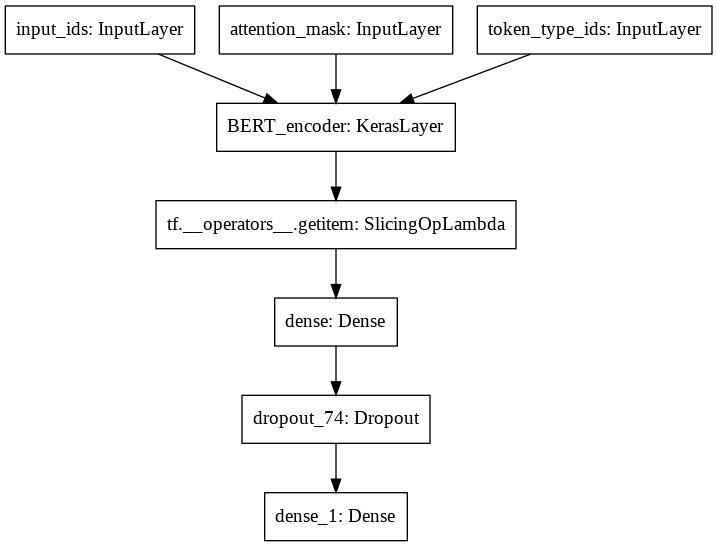

In [24]:
tf.keras.utils.plot_model(model)

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    input_x, train_labels, 
    validation_split=0.2,
    epochs=5,
    #callbacks=[checkpoint],
    batch_size=32,
    verbose=1)

Epoch 1/5
41/41 [==============================] - 2s 61ms/step - loss: 0.2048 - accuracy: 0.9261 - val_loss: 0.7135 - val_accuracy: 0.7866
Epoch 2/5
41/41 [==============================] - 2s 58ms/step - loss: 0.1494 - accuracy: 0.9451 - val_loss: 0.9126 - val_accuracy: 0.7622
Epoch 3/5
41/41 [==============================] - 2s 58ms/step - loss: 0.0989 - accuracy: 0.9627 - val_loss: 0.8632 - val_accuracy: 0.7744
Epoch 4/5
41/41 [==============================] - 2s 59ms/step - loss: 0.0793 - accuracy: 0.9726 - val_loss: 0.8576 - val_accuracy: 0.7896
Epoch 5/5
41/41 [==============================] - 2s 57ms/step - loss: 0.0525 - accuracy: 0.9848 - val_loss: 0.7206 - val_accuracy: 0.8140


In [27]:
# 0 = 'Negative':
# 1 = 'Positive':
# 2 = 'Neutral':

input_test = bert_encode(['Επιχείρηση Βολευτική έδρα!  Βασίλης Οικονόμου:  Από το ΠΑΣΟΚ διαγράφηκε απο το ΓΑΠ επειδη ΔΕΝ ψήφισε το Μνημόνιο...'], bert_preprocess_model)
print(input_test)
output = model(input_test)
print()
print(np.array(output[0]))

(array([[  101,  1314, 16357,   668,  1351,   108,  3113, 12078,   143,
          352,   345,  1609,  5294,   956,   352,   345, 18408,   593,
          366, 11598,   345,  3818,   121,   121,   121,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
     

Model saving/loading on TPUs
When loading and saving models TPU models from/to the local disk, the experimental_io_device option must be used. The technical explanation is at the end of this section. It can be omitted if writing to GCS because TPUs have direct access to GCS. This option does nothing on GPUs.

In [28]:
# Save the model

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save('./model', options=save_locally) # saving in Tensorflow's "SavedModel" format


In [31]:
# Load the model

with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    model = tf.keras.models.load_model('./model', options=load_locally) # loading in Tensorflow's "SavedModel" format


In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooler_output': (N 112921344   input_ids[0][0]                  
                                                                 attention_mask[0][0]         